**1. Strain Calculation**

In [1]:
# ===============================
# Step 1: Import libraries
# ===============================
import pandas as pd
import numpy as np

# ===============================
# Step 2: Load dataset
# ===============================
# Load sheet
from google.colab import files
file_upload_dict = files.upload()
# Extract the filename from the dictionary
file_path = list(file_upload_dict.keys())[0]
df = pd.read_excel(file_path, sheet_name="Testing Result")

# ===============================
# Step 3: Clean column names
# ===============================
df.columns = [
    "R_inf", "V_inf",
    "R_8000", "V_8000",
    "R_6000", "V_6000",
    "R_4000", "V_4000",
    "R_2000", "V_2000",
    "R_1000", "V_1000"
]

# ===============================
# Step 4: Define constants
# ===============================
G_f = 2.13        # Gauge factor
G = 541.6344         # Amplifier gain
thickness = 2.10  # thickness in mm

# ===============================
# Step 5: Compute means
# ===============================
means = df.mean()

# Baseline at infinity
V_inf = means["R_inf"]

# ===============================
# Step 6: Define radii of curvature (mm)
# ===============================
radii = {
    "R_8000": 8000,
    "R_6000": 6000,
    "R_4000": 4000,
    "R_2000": 2000,
    "R_1000": 1000
}

# ===============================
# Step 7: Compute actual strain, theoretical strain, and error
# ===============================
results = []

for r_col, v_col in zip(radii.keys(),
                        ["V_8000", "V_6000", "V_4000", "V_2000", "V_1000"]):
    V_R = means[r_col]
    V_amp = V_R - V_inf   # corrected definition
    V_s   = means[v_col]

    # Actual strain (from amplifier formula)
    actual = (4 / G_f) * ((V_amp / (G * V_s)) / (1 - 2 * (V_amp / (G * V_s)))) * 1e6  # microstrain

    # Theoretical strain = (t/2) / R
    theory = (thickness / 2) / radii[r_col] * 1e6  # also in microstrain

    # Error percentage
    error = ((actual - theory) / theory) * 100

    results.append([radii[r_col], actual, theory, error])

# ===============================
# Step 8: Build results DataFrame
# ===============================
strain_comparison = pd.DataFrame(results, columns=["Radius (mm)", "Actual (µε)", "Theoretical (µε)", "Error (%)"])
strain_comparison.set_index("Radius (mm)", inplace=True)

# ===============================
# Step 9: Display results
# ===============================
print("=== Mean Values of Each Column ===")
print(means)
print("\n=== Comparison: Actual vs Theoretical Strain ===")
print(strain_comparison)

Saving Group 7_Lab 1_Testing.xlsx to Group 7_Lab 1_Testing.xlsx
=== Mean Values of Each Column ===
R_inf     0.326162
V_inf     5.035101
R_8000    0.507879
V_8000    5.035000
R_6000    0.567778
V_6000    5.035000
R_4000    0.714949
V_4000    5.035051
R_2000    1.120808
V_2000    5.035000
R_1000    1.895657
V_1000    5.036717
dtype: float64

=== Comparison: Actual vs Theoretical Strain ===
             Actual (µε)  Theoretical (µε)  Error (%)
Radius (mm)                                          
8000          125.149328            131.25  -4.648131
6000          166.409308            175.00  -4.908967
4000          267.797722            262.50   2.018180
2000          547.522281            525.00   4.289958
1000         1081.649384           1050.00   3.014227


**2. Relationship of Voltage Output to Inverse Radius and Error Comparison**

=== Mean Values of Each Column ===
R_inf     0.326162
V_inf     5.035101
R_8000    0.507879
V_8000    5.035000
R_6000    0.567778
V_6000    5.035000
R_4000    0.714949
V_4000    5.035051
R_2000    1.120808
V_2000    5.035000
R_1000    1.895657
V_1000    5.036717
dtype: float64

=== Comparison: Actual vs Theoretical Strain ===
             ΔV = V_R - V_∞ (V)  V_supply mean (V)  Actual (µε)  \
Radius (mm)                                                       
8000                   0.181717           5.035000   125.149328   
6000                   0.241616           5.035000   166.409308   
4000                   0.388788           5.035051   267.797722   
2000                   0.794646           5.035000   547.522281   
1000                   1.569495           5.036717  1081.649384   

             Theoretical (µε)  Error (%)  
Radius (mm)                               
8000                   131.25  -4.648131  
6000                   175.00  -4.908967  
4000                   262.50 

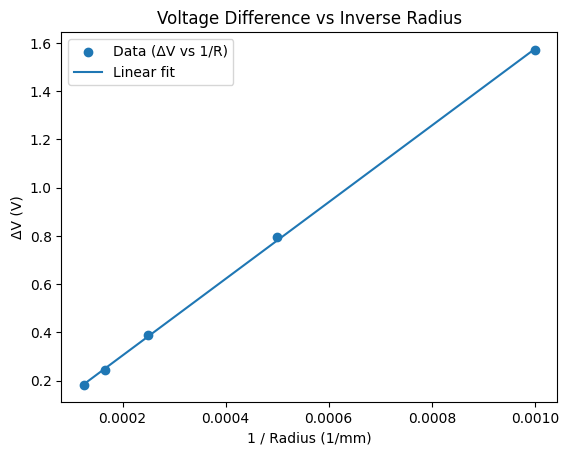

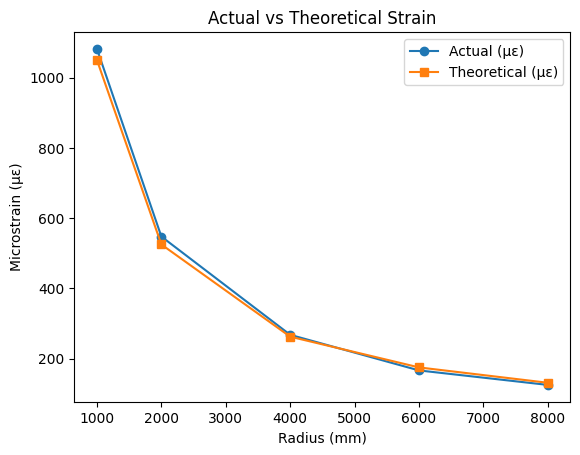

In [2]:
# ===============================
# Step 1: Import libraries
# ===============================
import pandas as pd
import numpy as np

# (Optional) plotting
import matplotlib.pyplot as plt

# Preserve order of columns and matching supply columns
r_cols_order = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]
v_cols_order = ["V_8000", "V_6000", "V_4000", "V_2000", "V_1000"]

# ===============================
# Step 7: Compute actual strain, theoretical strain, and error
# ===============================
results = []

for r_col, v_col in zip(r_cols_order, v_cols_order):
    V_R = means[r_col]
    V_amp = V_R - V_inf                     # Voltage difference ΔV
    V_s   = means[v_col]

    # Actual strain (microstrain) from your (positive sign) formula
    actual = (4 / G_f) * ((V_amp / (G * V_s)) / (1 - 2 * (V_amp / (G * V_s)))) * 1e6

    # Theoretical strain = (t/2) / R  (also convert to microstrain)
    theory = (thickness / 2) / radii[r_col] * 1e6

    # Error percentage
    error = ((actual - theory) / theory) * 100

    results.append([radii[r_col], V_amp, V_s, actual, theory, error])

# Build comparison DataFrame
strain_comparison = pd.DataFrame(
    results,
    columns=[
        "Radius (mm)", "ΔV = V_R - V_∞ (V)", "V_supply mean (V)",
        "Actual (µε)", "Theoretical (µε)", "Error (%)"
    ]
).set_index("Radius (mm)")

# ===============================
# Step 8: Linear regression
# Relation: ΔV = m * (1/R) + b
# ===============================
# Prepare x = 1/R (1/mm) and y = ΔV (V)
x_invR = np.array([1.0 / radii[r_col] for r_col in r_cols_order])       # 1/mm
y_dV   = np.array([means[r_col] - V_inf for r_col in r_cols_order])     # V

# Fit linear model (degree 1)
m, b = np.polyfit(x_invR, y_dV, 1)

# Predictions & R^2
y_pred = m * x_invR + b
ss_tot = np.sum((y_dV - np.mean(y_dV))**2)
ss_res = np.sum((y_dV - y_pred)**2)
r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

# Regression table for display
regression_table = pd.DataFrame({
    "Radius (mm)": [radii[r_col] for r_col in r_cols_order],
    "1/R (1/mm)": x_invR,
    "ΔV (V)": y_dV,
    "ΔV_pred (V)": y_pred
}).set_index("Radius (mm)")

# ===============================
# Step 9: Print results
# ===============================
print("=== Mean Values of Each Column ===")
print(means)
print("\n=== Comparison: Actual vs Theoretical Strain ===")
print(strain_comparison.round(6))

print("\n=== Linear Regression: ΔV vs 1/R ===")
print(f"Slope m        = {m:.6e} V·mm")
print(f"Intercept b    = {b:.6e} V")
print(f"R^2            = {r2:.6f}")
print("\nRegression Data:")
print(regression_table.round(9))

# ===============================
# Step 10: Plotting
# ===============================
# ΔV vs 1/R with regression line
plt.figure()
plt.scatter(x_invR, y_dV, label="Data (ΔV vs 1/R)")
# sort for a clean line
idx = np.argsort(x_invR)
plt.plot(x_invR[idx], y_pred[idx], label="Linear fit")
plt.xlabel("1 / Radius (1/mm)")
plt.ylabel("ΔV (V)")
plt.title("Voltage Difference vs Inverse Radius")
plt.legend()
plt.show()

# Actual vs Theoretical microstrain vs Radius
plt.figure()
plt.plot(strain_comparison.index, strain_comparison["Actual (µε)"], marker='o', label="Actual (µε)")
plt.plot(strain_comparison.index, strain_comparison["Theoretical (µε)"], marker='s', label="Theoretical (µε)")
plt.xlabel("Radius (mm)")
plt.ylabel("Microstrain (µε)")
plt.title("Actual vs Theoretical Strain")
plt.legend()
plt.show()


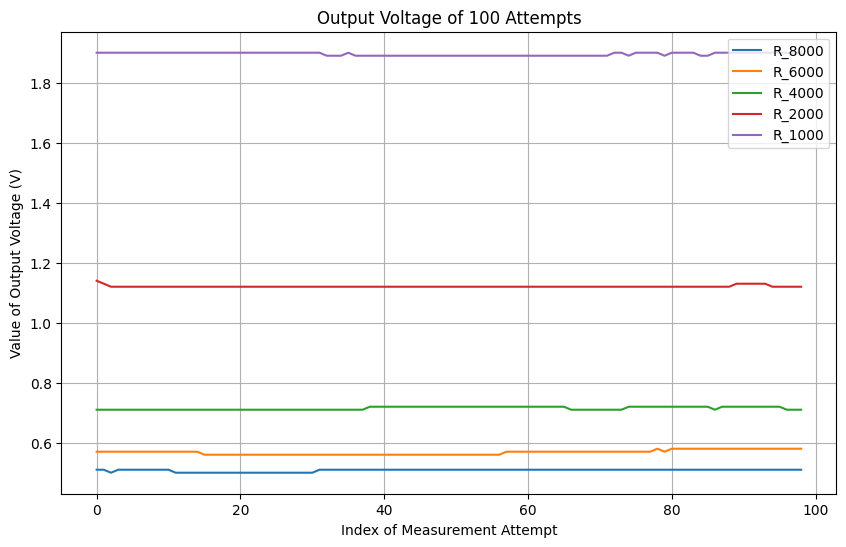

In [3]:
# ===============================
# Step 14: Plotting Output Values vs. Measurement Attempt
# ===============================

plt.figure(figsize=(10, 6))

r_cols = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]

for col in r_cols:
    plt.plot(df.index, df[col], linestyle='-', label=col)

plt.xlabel("Index of Measurement Attempt")
plt.ylabel("Value of Output Voltage (V)")
plt.title("Output Voltage of 100 Attempts")
plt.legend()
plt.grid(True)
plt.show()

**3. Uncertainty Analysis**


=== Standard Deviation of Each Voltage Measurement ===
R_8000    0.004109
R_6000    0.007634
R_4000    0.005025
R_2000    0.003089
R_1000    0.004982
dtype: float64


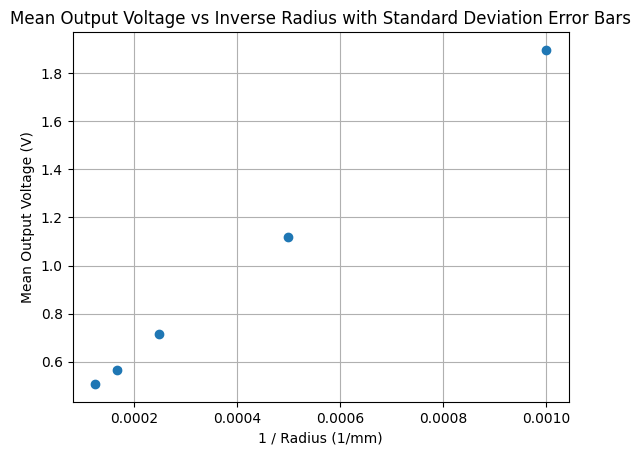


=== Coefficient of Variation (Std Dev / Mean) ===
R_8000    0.008090
R_6000    0.013445
R_4000    0.007029
R_2000    0.002756
R_1000    0.002628
dtype: float64


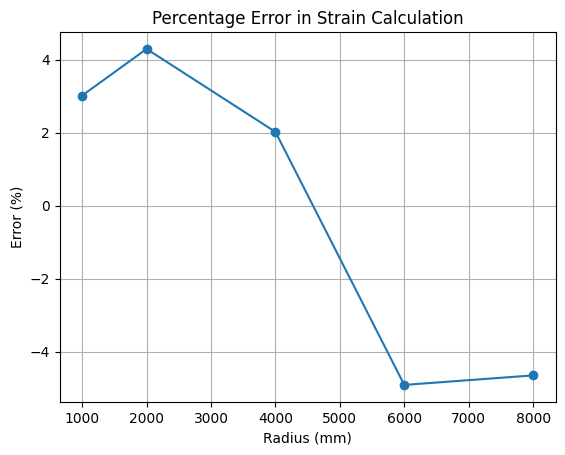

In [8]:
# ===============================
# Step 11: Uncertainty Analysis
# ===============================

# Calculate standard deviation for each voltage measurement
std_dev = df[["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]].std()

print("\n=== Standard Deviation of Each Voltage Measurement ===")
print(std_dev)

# Estimate the uncertainty in the calculated actual strain
# This is a simplified approach, a full uncertainty analysis would involve partial derivatives
# of the actual strain formula with respect to each variable (V_R, V_inf, G, G_f, V_s)
# and their respective uncertainties.

# For a simplified visualization, we can use the standard deviation of the R measurements
# as a proxy for the variability in the input voltage signal.

# Let's plot the standard deviation of the voltage measurements against the inverse radius
r_cols_order = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]
x_invR = np.array([1.0 / radii[r_col] for r_col in r_cols_order])

plt.figure()
plt.errorbar(x_invR, means[r_cols_order], yerr=std_dev, fmt='o', capsize=3)
plt.xlabel("1 / Radius (1/mm)")
plt.ylabel("Mean Output Voltage (V)")
plt.title("Mean Output Voltage vs Inverse Radius with Standard Deviation Error Bars")
plt.grid(True)
plt.show()

# Another way to look at uncertainty is the coefficient of variation (Std Dev / Mean)
cov = std_dev / means[r_cols_order]

print("\n=== Coefficient of Variation (Std Dev / Mean) ===")
print(cov)

# Plotting the error percentage calculated earlier
plt.figure()
plt.plot(strain_comparison.index, strain_comparison["Error (%)"], marker='o')
plt.xlabel("Radius (mm)")
plt.ylabel("Error (%)")
plt.title("Percentage Error in Strain Calculation")
plt.grid(True)
plt.show()

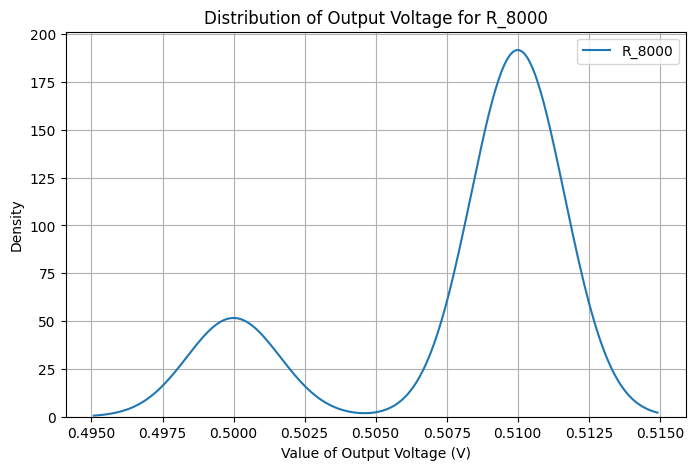

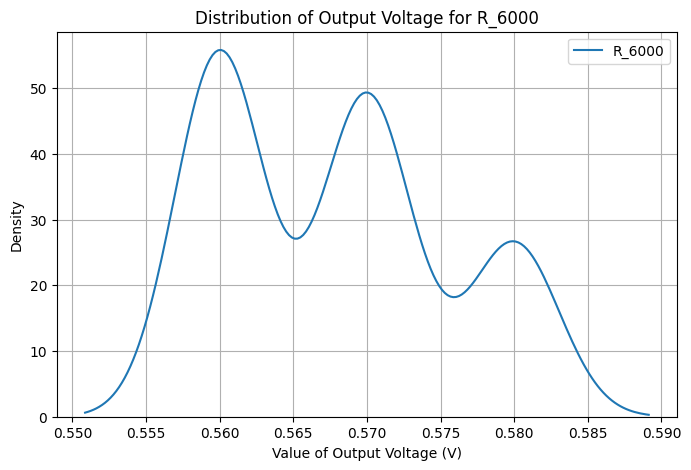

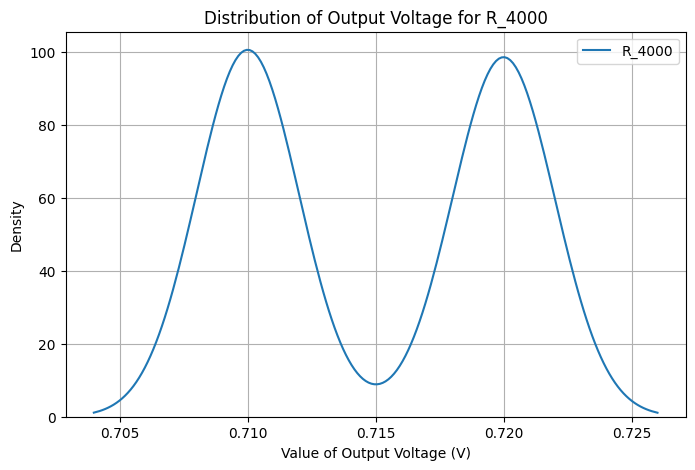

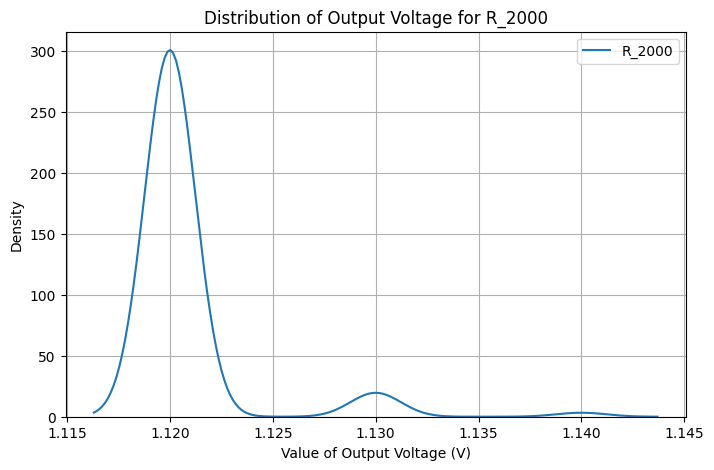

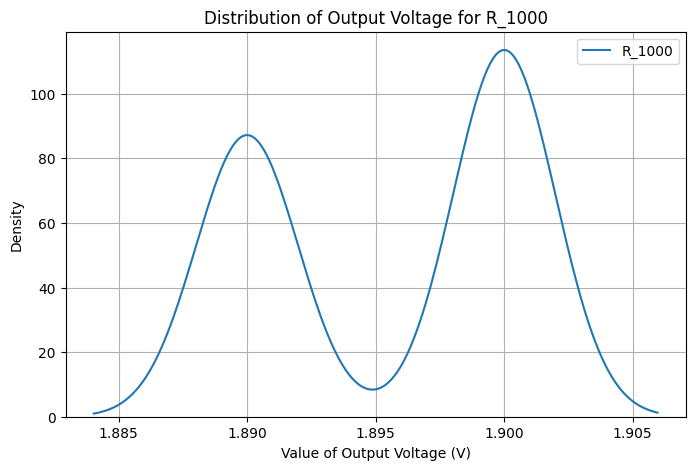

In [10]:
# ===============================
# Step 16: Plotting Distribution Data for Each Radius (Separate Figures - KDE only)
# ===============================

import seaborn as sns
import matplotlib.pyplot as plt

r_cols = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]

for col in r_cols:
    plt.figure(figsize=(8, 5)) # Create a new figure for each plot
    sns.kdeplot(df[col], label=col) # Use kdeplot for distribution line only
    plt.xlabel("Value of Output Voltage (V)")
    plt.ylabel("Density")
    plt.title(f"Distribution of Output Voltage for {col}") # Add column name to title
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# ===============================
# Step 17: Normalize data using t-value and degree of freedom
# ===============================

from scipy.stats import t

# Calculate t-values for each data point
# t = (x - mean) / (std_dev / sqrt(n)) - This is for comparing a sample mean to a population mean
# If we want to standardize individual data points using sample statistics, we use:
# t = (x - mean) / std_dev

normalized_df = pd.DataFrame()

r_cols = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]

for col in r_cols:
    # Calculate mean and standard deviation for the current column
    col_mean = df[col].mean()
    col_std = df[col].std()

    # Calculate t-value for each data point in the column
    # Using the formula for standardizing individual data points
    normalized_df[col] = (df[col] - col_mean) / col_std

# The degrees of freedom for each group would be n-1, but for normalizing individual data points
# into t-values, we are essentially standardizing them based on the sample distribution.
# The concept of degrees of freedom is more relevant when using the t-distribution for inference (e.g., t-tests, confidence intervals).
# For simply transforming the data points, the formula (x - mean) / std_dev is the standard way to get a t-score relative to the sample.

print("=== Normalized Data (t-values) ===")
display(normalized_df.head())

=== Normalized Data (t-values) ===


,R_8000,R_6000,R_4000,R_2000,R_1000
0,0.516247,0.291099,-0.984937,6.212173,0.871838
1,0.516247,0.291099,-0.984937,2.975304,0.871838
2,-1.917490,0.291099,-0.984937,-0.261565,0.871838
3,0.516247,0.291099,-0.984937,-0.261565,0.871838
4,0.516247,0.291099,-0.984937,-0.261565,0.871838


**4. Normalized Distribution**

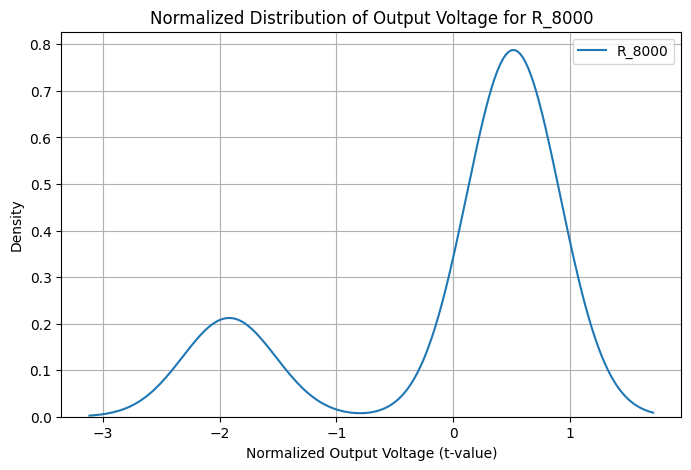

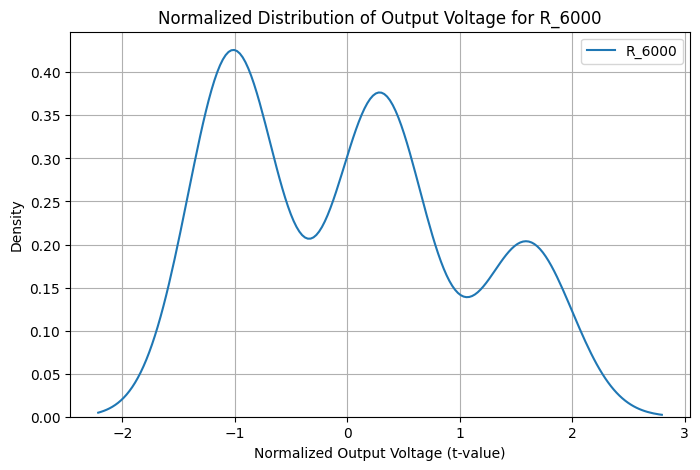

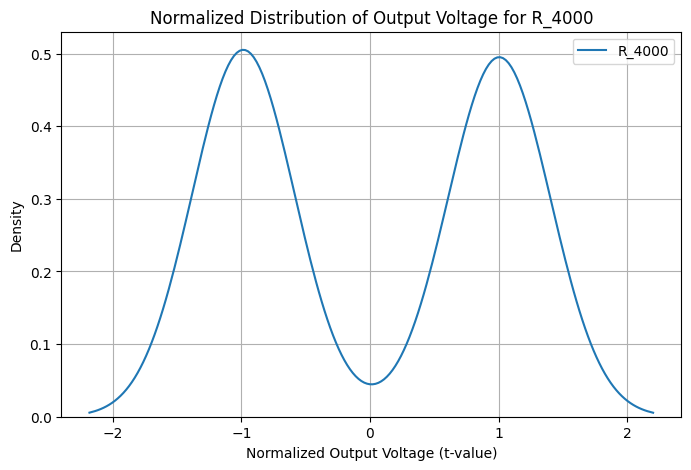

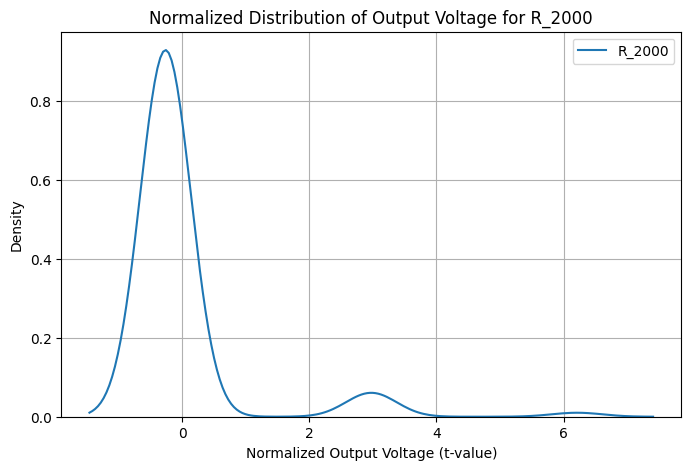

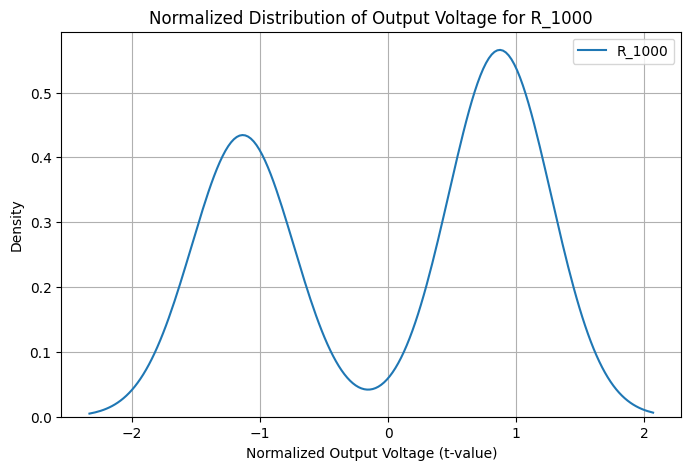

In [14]:
# ===============================
# Step 18: Plotting Normalized Distribution Data for Each Radius (Separate Figures - KDE only)
# ===============================

import seaborn as sns
import matplotlib.pyplot as plt

r_cols = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]

for col in r_cols:
    plt.figure(figsize=(8, 5)) # Create a new figure for each plot
    sns.kdeplot(normalized_df[col], label=col) # Use kdeplot for distribution line only
    plt.xlabel("Normalized Output Voltage (t-value)")
    plt.ylabel("Density")
    plt.title(f"Normalized Distribution of Output Voltage for {col}") # Add column name to title
    plt.legend()
    plt.grid(True)
    plt.show()

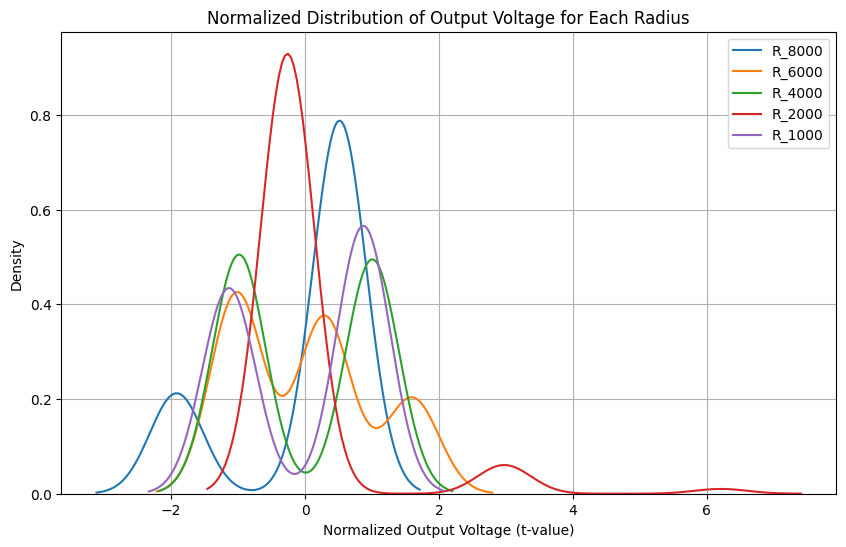

In [16]:
# ===============================
# Step 19: Plotting Normalized Distribution Data Together
# ===============================

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

r_cols = ["R_8000", "R_6000", "R_4000", "R_2000", "R_1000"]

for col in r_cols:
    sns.kdeplot(normalized_df[col], label=col)

plt.xlabel("Normalized Output Voltage (t-value)")
plt.ylabel("Density")
plt.title("Normalized Distribution of Output Voltage for Each Radius")
plt.legend()
plt.grid(True)
plt.show()